In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = np.load("mar_data.npy")

## 初期化

In [3]:
eta0 = np.array([0.5, 0.5])
c0 = np.array([0.0, 0.0])
phi0 = np.array([[0.9], [1.1]])
sigma0 = np.array([1.0, 1.0])

## EMアルゴリズム

In [4]:
p = 1

In [5]:
def e_step(x, eta, c, phi, sigma):
    z = np.fliplr(np.lib.stride_tricks.sliding_window_view(x[:-1], p))
    e = x[p:] - (c[:, np.newaxis] + np.einsum("kp,tp->kt", phi, z))
    log_resp = np.log(eta)[:, np.newaxis] + scipy.stats.norm.logpdf(e, scale=sigma[:, np.newaxis])
    log_resp -= scipy.special.logsumexp(log_resp, axis=0, keepdims=True)
    return log_resp

In [6]:
def optimize_eta(gamma):
    return gamma / gamma.sum()
def optimize_beta(X, Z):
    beta = []
    for (Z_k, X_k) in zip(Z, X):
        (beta_k, *_) = np.linalg.lstsq(Z_k, X_k, rcond=None)
        beta.append(beta_k)
    return np.stack(beta)
def optimize_sq_sigma(beta, X, Z, gamma):
    return np.square(X - np.einsum("ktp,kp->kt", Z, beta)).sum(axis=-1) / gamma

def m_step(x, log_resp):
    resp = np.exp(log_resp)
    sqrt_resp = np.sqrt(resp)
    gamma = resp.sum(axis=-1)
    
    X = sqrt_resp * x[p:]
    Z = np.fliplr(np.lib.stride_tricks.sliding_window_view(x[:-1], p))
    Z = np.hstack([np.ones((Z.shape[0], 1)), Z])
    Z = sqrt_resp[:, :, np.newaxis] * Z
    
    eta_ = optimize_eta(gamma)
    beta_ = optimize_beta(X, Z)
    sigma_ = np.sqrt(optimize_sq_sigma(beta_, X, Z, gamma))
    
    c_ = beta_[:, 0]
    phi_ = beta_[:, 1:]
    return (eta_, c_, phi_, sigma_)

In [7]:
def log_likelihood(x, eta, c, phi, sigma):
    z = np.fliplr(np.lib.stride_tricks.sliding_window_view(x[:-1], p))
    e = x[p:] - (c[:, np.newaxis] + np.einsum("kp,tp->kt", phi, z))
    log_p = np.log(eta)[:, np.newaxis] + scipy.stats.norm.logpdf(e, scale=sigma[:, np.newaxis])
    return scipy.special.logsumexp(log_p, axis=0).sum()

### 収束の様子を確認

In [8]:
eta = eta0
c = c0
phi = phi0
sigma = sigma0

history = [log_likelihood(x, eta, c, phi, sigma)]
for _ in range(10):
    log_resp = e_step(x, eta, c, phi, sigma)
    (eta, c, phi, sigma) = m_step(x, log_resp)
    L = log_likelihood(x, eta, c, phi, sigma)
    history.append(L)

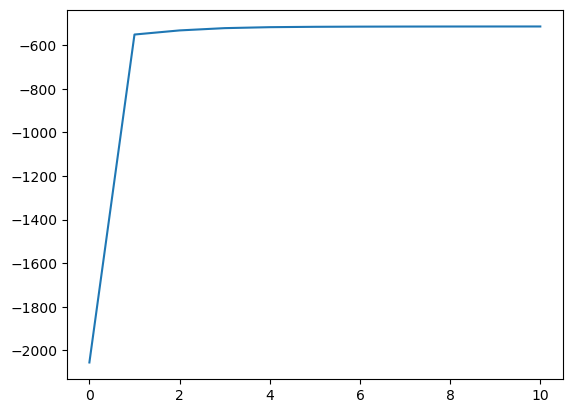

In [9]:
(fig, ax) = plt.subplots()
ax.plot(history)
plt.show()

### モデルを同定

In [10]:
MAX_ITER = 100
CONVERGENCE_THRESHOLD = 1e-3

def identify_mar(x, eta0, c0, phi0, sigma0):
    eta = eta0
    c = c0
    phi = phi0
    sigma = sigma0
    
    L = log_likelihood(x, eta, c, phi, sigma)
    for _ in range(MAX_ITER):
        log_resp = e_step(x, eta, c, phi, sigma)
        (eta, c, phi, sigma) = m_step(x, log_resp)
        L_ = log_likelihood(x, eta, c, phi, sigma)
        if abs(L_ - L) < CONVERGENCE_THRESHOLD:
            break
        L = L_
    
    return (eta, c, phi, sigma)

In [11]:
(eta, c, phi, sigma) = identify_mar(x, eta0, c0, phi0, sigma0)
print(eta)
print(c)
print(phi)
print(sigma)

[0.48333192 0.51666808]
[0.1192715  0.09443656]
[[0.41457039]
 [1.0954469 ]]
[5.18348074 0.96523573]
